In [1]:
# importações EDA

import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# importação de ML
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Otimização de hiperparâmetros
import optuna

In [2]:
# Carregar dataset

df_segmento = pd.read_csv('./datasets/segmento.csv')

### EDA

In [3]:
# Visualizar os dados
df_segmento.head()

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver


In [4]:
# Estrutura do Dataset
df_segmento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [5]:
# Valores possíveis - Atividades Categóricas

df_segmento['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [6]:
df_segmento['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [7]:
df_segmento['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [8]:
# Distribuição da Variável Segmento de Cliente (Target)
contagem_target = df_segmento['segmento_de_cliente'].value_counts()
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [9]:
# Criar uma lista ordenada do target
lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

In [10]:
# Distribuição da Variável Target - Contagem
px.bar(
    contagem_target,
    color=contagem_target.index,
    title='Distribuição da Variável Segmento de Cliente',
    category_orders={ 'segmento_de_cliente': lista_segmentos }
    )

In [11]:
# Distribuiçãode Variável Target - Percentual
percentual_target = contagem_target / len(df_segmento) * 100
px.bar(
    percentual_target,
    color=percentual_target.index,
    category_orders={ 'segmento_de_cliente': lista_segmentos }
)

In [12]:
# Distribuição Variável Localização

percentual_localizacao = df_segmento.value_counts('localizacao') / len(df_segmento) * 100
px.bar(
    percentual_localizacao,
    color=percentual_localizacao.index
)

In [13]:
# Distribuição Variável Atividade Econômica

percentual_atividade_economica = df_segmento.value_counts('atividade_economica') / len(df_segmento) * 100
px.bar(
    percentual_atividade_economica,
    color=percentual_atividade_economica.index
)

In [14]:
# Distribuição Variável Atividade Inovação

percentual_inovacao = df_segmento.value_counts('inovacao') / len(df_segmento) * 100
px.bar(
    percentual_inovacao,
    color=percentual_inovacao.index
)

In [15]:
# Cross tab - Tabela de Contingência entre localização e segmento de cliente (Target)

crosstab_localizacao = pd.crosstab(df_segmento['localizacao'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_localizacao)
tabela_localizacao.show()

In [16]:
# Cross tab - Tabela de Contingência entre atividade econômica e segmento de cliente (Target)

crosstab_atividade_economica = pd.crosstab(df_segmento['atividade_economica'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_atividade_economica = ff.create_table(crosstab_atividade_economica)
tabela_atividade_economica.show()

In [17]:
# Cross tab - Tabela de Contingência entre inovacao e segmento de cliente (Target)

crosstab_inovacao = pd.crosstab(df_segmento['inovacao'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_inovacao = ff.create_table(crosstab_inovacao)
tabela_inovacao.show()

In [18]:
# Distribuição de Idade da Empresa
px.histogram(data_frame=df_segmento, x='idade', nbins=20)

In [19]:
# Distribuição de Faturamento mensal
px.histogram(data_frame=df_segmento, x='faturamento_mensal', nbins=20)

In [20]:
# BoxPlot entre idade e Segmento
px.box(data_frame=df_segmento, x='segmento_de_cliente', y='idade', color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [21]:
# BoxPlot entre Faturamento e Segmento
px.box(data_frame=df_segmento, x='segmento_de_cliente', y='faturamento_mensal', color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [22]:
# Teste de QuiQuadrado de Pearson
# H0 - as variáveis são independentes
# H1 - as variáveis são dependentes
# Se p-valor < 0.05, rejeitamos H0
# Se aceitar, as variáveis são independentes

valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_segmento, x='segmento_de_cliente', y='inovacao')

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7343: RuntimeWarning:

divide by zero encountered in power

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7343: RuntimeWarning:

invalid value encountered in multiply

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7340: RuntimeWarning:

divide by zero encountered in divide



In [23]:
# Valor esperado -> frequência esperada se não houvesse relação entre as variáveis
# É calculado utilizando a distribuição assumida no teste qui-quadrado
valor_esperado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,21.008,23.028,22.624,19.392,17.372,17.372,21.816,21.412,18.988,18.988
Gold,1.664,1.824,1.792,1.536,1.376,1.376,1.728,1.696,1.504,1.504
Silver,27.040,29.640,29.120,24.960,22.360,22.360,28.080,27.560,24.440,24.440
Starter,2.288,2.508,2.464,2.112,1.892,1.892,2.376,2.332,2.068,2.068


In [24]:
# Valor Observado -> frequência real dos dados coletados
valor_observado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,36,44,32,22,12,14,15,12,9,6
Gold,0,0,0,0,0,3,0,5,4,4
Silver,10,5,20,25,30,25,38,36,34,37
Starter,6,8,4,1,1,1,1,0,0,0


In [25]:
# Estatísticas -> estatísticas do teste qui-quadrado
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,164.29399,27.0,0.0,0.33095,0.99850
1,cressie-read,0.66667,165.49946,27.0,0.0,0.33216,0.99861
2,log-likelihood,0.00000,181.48878,27.0,0.0,0.34784,0.99951
3,freeman-tukey,-0.50000,NaN,27.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,27.0,0.0,inf,NaN
5,neyman,-2.00000,NaN,27.0,NaN,NaN,NaN


- As variáveis localização e segmento de cliente são independentes. Qui-Quadrado (p-value = 0.81714)
- As variáveis atividade econômica e segmento de cliente são independentes. Qui-Quadrado (p-value = 0.35292)
- As variáveis inovação e segmento de cliente não são independentes. Qui-Quadrado (p-value = 0.0)

### Treinamento do Modelo

In [26]:
# Separar X e y
X = df_segmento.drop(columns='segmento_de_cliente')
y = df_segmento['segmento_de_cliente']

In [27]:
# Visualizando variáveis categóricas
X.select_dtypes(include='object').head()

,atividade_economica,localizacao
0,Comércio,Rio de Janeiro
1,Comércio,São Paulo
2,Comércio,São Paulo
3,Indústria,São Paulo
4,Agronegócio,São Paulo


In [28]:
# O algoritmo Decision Tree não aceita variáveis categóricas no Scikit-Learn

# Pipeline de Pré-processamento
# OneHotEncode nas variáveis categóricas
# Treinamento do Modelo

#Lista de variáveis categóricas
categorical_features = ['atividade_economica', 'localizacao']

# Criar um transformador de variáveis categóricas usando OneHotEncoder
categorical_transformes = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Quando for fazer um particionamento, se encontrar uma categoria desconhecida, ele ignora
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformes, categorical_features)
    ]
)

# Pipeline de Pré-processamento e o Modelo de Árvore de Decisão
dt_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]
)

In [29]:
# Vamos treinar o modelo usando o cross_validate do Scikit-Learn usando o StratifiedKFold, ele cria partições estratificadas com base em uma variável target
# O StratifiedKFold é uma técnica de validação cruzada que mantém a proporção de classes em cada partição
# Oque é uma estraificação? É a divisão de uma população em subgrupos que são mutuamente exclusivos e coletivamente exaustivos

### Validação Cruzada

In [30]:
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
metrics_result = cross_validate(estimator=dt_model, X=X, y=y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)

In [31]:
# Mostrar o retorno do Cross Validation
metrics_result

{'fit_time': array([0.00687099, 0.00194097, 0.00182104]),
 'score_time': array([0.00246716, 0.00111723, 0.00103688]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
        

In [32]:
# Média da Acuáracia considerando as 3 partições
metrics_result['test_accuracy'].mean()

np.float64(0.4739917754851743)

In [33]:
# Oque é Acurácia?
# Acurácia é a proporção de previsões corretas feitas pelo modelo pelo total de previsões feitas
# Acurácia = (VP + VN) / (VP + VN + FP + FN)
# VP - Verdadeiro Positivo
# VN - Verdadeiro Negativo
# FP - Falso Positivo
# FN - Falso Negativo

# Acurácia do Modelo = 47%

In [34]:
# Fazendo predições usando o Cross Validation

y_pred = cross_val_predict(estimator=dt_model, X=X, y=y, cv=cv_folds) 

In [35]:
# Avaliar o desempenho do modelo

classification_report_str = classification_report(y, y_pred)
print('Relatório de Classificação: ' + classification_report_str)

Relatório de Classificação:               precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/luca/Documents/development/rocketseat/ML/modelo_decision_tree/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



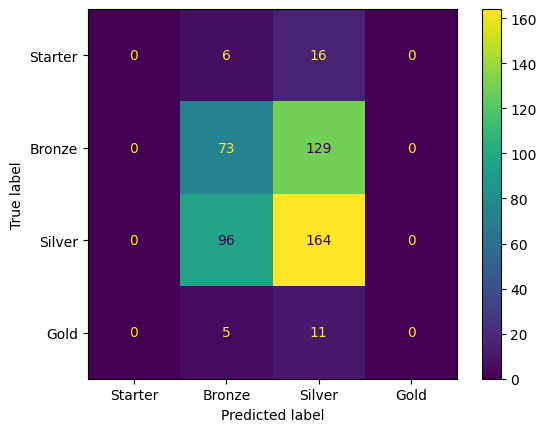

In [36]:
# Matriz de Confusão -> Ferramenta para avaliar o desempenho de um algoritmo de classificação
# A diagonal principal da matriz de confusão mostra o número de previsões corretas
# A diagonal secundária mostra o número de previsões incorretas

confusion_matrix_modelo = confusion_matrix(y, y_pred, labels=lista_segmentos)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_modelo, display_labels=lista_segmentos)
disp.plot()

In [37]:
# Conclusão, o modelo não está performando bem, vamos tentar otimizar os hiperparâmetros do modelo
# Tuning de Hiperparâmetros

### Tuning de Hiperparâmetros

In [38]:
# Ajustar hiperparâmetros do modelo usando Optuna
# min_samples_leaf = número mínimo de amostras necessárias para ser um nó folha (terminal)

# Quando você tem valores muito altos, você tende a evitar o overfitting, você terá mais elementos para fazer a média
# A árvore não irá aprender muito com os dados de treinamento, para não ter problemas para generalizar
# Quando você tem valores muito baixos, você tende a overfitting, a árvore irá aprender muito com os dados de treinamento

# max_depth = profundidade máxima da árvore
# Você tem o nó raiz, que é o nível 0, e a partir disso você tem os nós filhos
# Se o max_depth for muito alto, você pode ter overfitting
# Se o max_depth for muito baixo, você pode ter underfitting

# Como é feito esse processo de tuning? O Optuna vai testar várias combinações de hiperparâmetros e vai escolher a melhor combinação

In [39]:
def decisiontree_optuna(trial): # trial é uma tentativa, para testar um conjunto de hiperparâmetros e ver qual é o melhor
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) # A cada vez que ele testar, ele vai testar um valor inteiro entre 1 e 20
    max_depth = trial.suggest_int('max_depth', 2, 8) # A cada vez que ele testar, ele vai testar um valor inteiro entre 2 e 8
    
    dt_model.set_params(classifier__min_samples_leaf=min_samples_leaf)
    dt_model.set_params(classifier__max_depth=max_depth)
    
    scores = cross_val_score(estimator=dt_model, X=X, y=y, cv=cv_folds, scoring='accuracy')
    
    return scores.mean()                       

In [40]:
# Executar a automação de experimentos
estudo_decisiontree = optuna.create_study(direction='maximize') # maximize -> queremos maximizar a acurácia
estudo_decisiontree.optimize(decisiontree_optuna, n_trials=200)

[I 2025-01-13 21:20:32,996] A new study created in memory with name: no-name-c09d1105-0d0e-47fb-b10a-d521f724293f
[I 2025-01-13 21:20:33,009] Trial 0 finished with value: 0.4699877353726283 and parameters: {'min_samples_leaf': 13, 'max_depth': 3}. Best is trial 0 with value: 0.4699877353726283.
[I 2025-01-13 21:20:33,021] Trial 1 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 14, 'max_depth': 6}. Best is trial 1 with value: 0.4739917754851743.
[I 2025-01-13 21:20:33,031] Trial 2 finished with value: 0.4620037034365005 and parameters: {'min_samples_leaf': 18, 'max_depth': 2}. Best is trial 1 with value: 0.4739917754851743.
[I 2025-01-13 21:20:33,042] Trial 3 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 1, 'max_depth': 6}. Best is trial 1 with value: 0.4739917754851743.
[I 2025-01-13 21:20:33,052] Trial 4 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 13, 'max_depth': 7}. Best is trial 1 with valu

In [41]:
# Mostrar melhor resultado e melhor conjunto de hiperparâmetros
print(f'Melhor acurácia: {estudo_decisiontree.best_value}')
print(f'Melhores parâmetros: {estudo_decisiontree.best_params}')

Melhor acurácia: 0.4740518962075848
Melhores parâmetros: {'min_samples_leaf': 17, 'max_depth': 2}


### Visualizar Árvore

In [42]:
# Preparar o conjunto de Dados para treinar e conseguir visualizar a árvore de decisão

X_train_tree = X.copy()
X_train_tree['localizacao_label'] = X_train_tree.localizacao.astype('category').cat.codes
X_train_tree['atividade_economica_label'] = X_train_tree.atividade_economica.astype('category').cat.codes
X_train_tree.drop(columns=['localizacao', 'atividade_economica'], axis=1, inplace=True)
X_train_tree.rename(columns={'localizacao_label': 'localizacao', 'atividade_economica_label': 'atividade_economica'}, inplace=True)
X_train_tree.head(10)


,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0
5,1629562.41,16,11,4,1,3
6,771179.95,13,0,1,3,3
7,707837.61,16,10,6,2,3
8,888983.66,17,10,1,0,1
9,1098512.64,13,9,3,1,2


In [43]:
# TREINAR O MODELO COM O CONJUNTO DE HIPERPARAÊTROS OTIMIZADOS

clf_decisiontree = DecisionTreeClassifier(min_samples_leaf=estudo_decisiontree.best_params['min_samples_leaf'],
                                          max_depth=estudo_decisiontree.best_params['max_depth'])

y_train_tree = y.copy()

clf_decisiontree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=17)

[Text(0.5, 0.8333333333333334, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.25, 0.5, 'faturamento_mensal <= 497183.891\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.432\nsamples = 19\nvalue = [6, 0, 0, 13]\nclass = Gold'),
 Text(0.375, 0.16666666666666666, 'gini = 0.414\nsamples = 146\nvalue = [106, 0, 35, 5]\nclass = Starter'),
 Text(0.75, 0.5, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = Starter'),
 Text(0.875, 0.16666666666666666, 'gini = 0.416\nsamples = 298\nvalue = [64.0, 16.0, 218.0, 0.0]\nclass = Silver')]

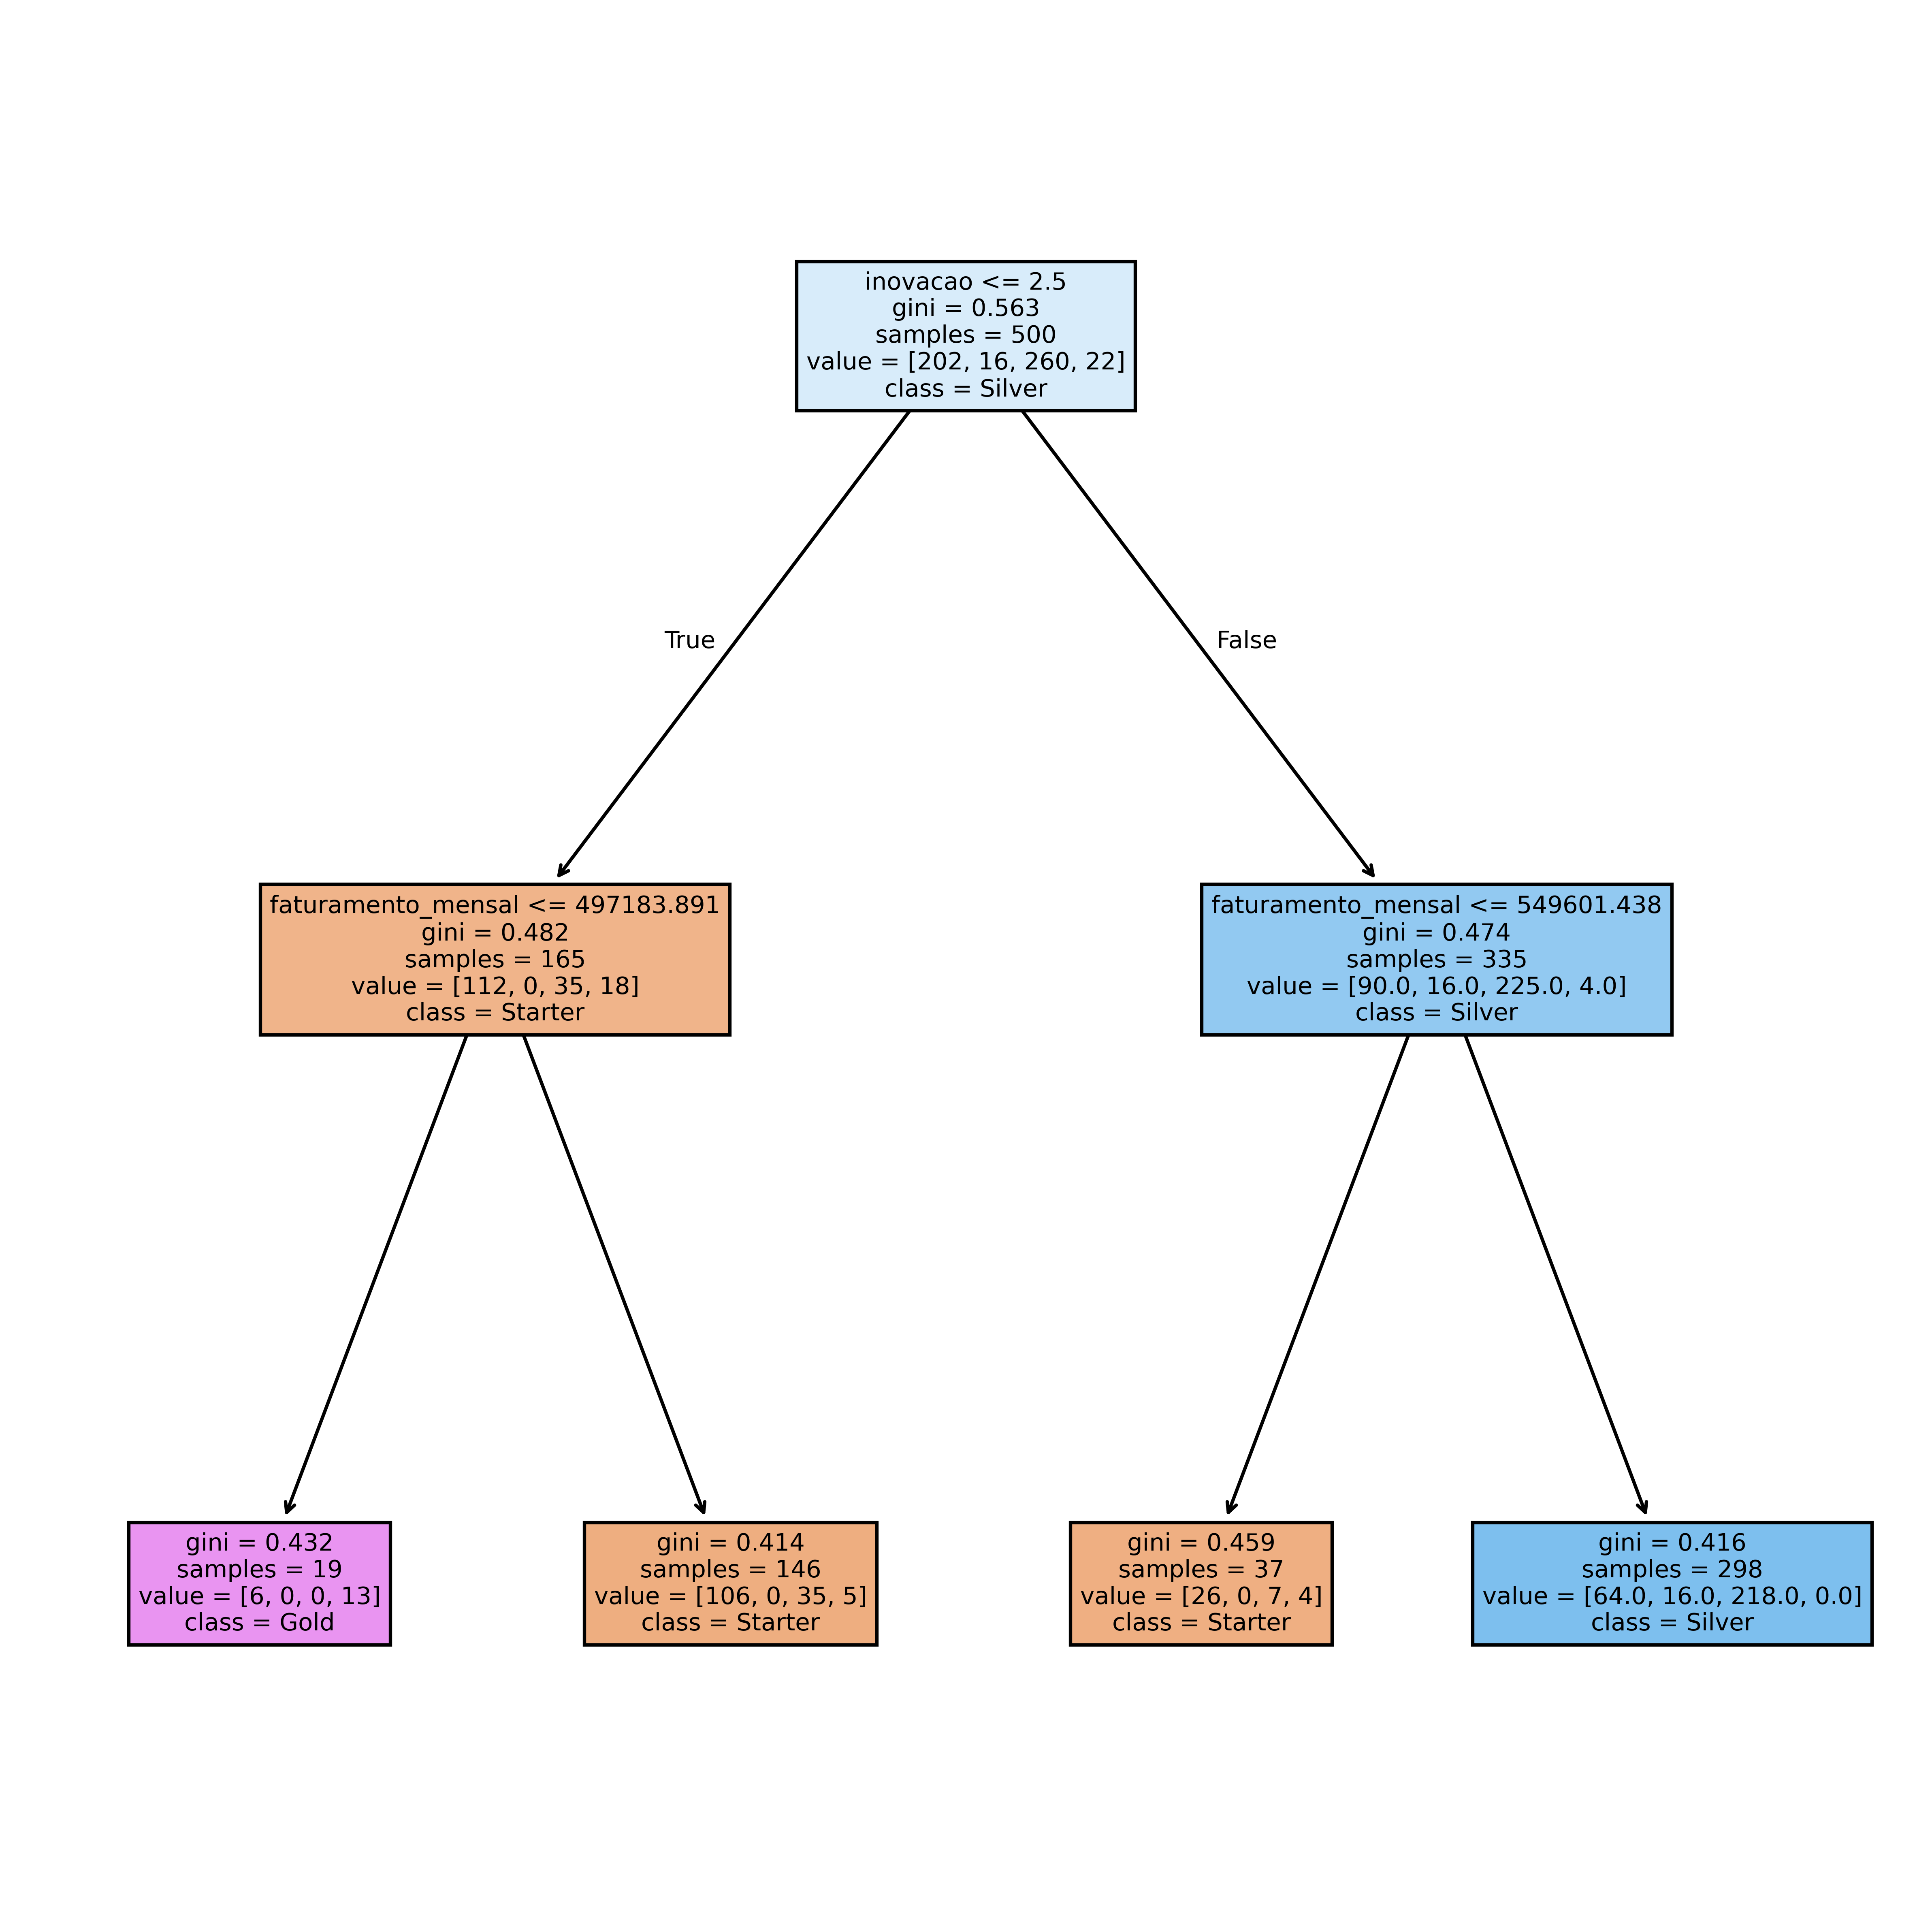

In [44]:
# Visualizar Árvore de Decisão com Plot Tree
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=600)

plot_tree(clf_decisiontree,
          feature_names=X_train_tree.columns.to_numpy(),
          class_names=lista_segmentos,
          filled=True)

In [45]:
### Salvar a Árvore de Decisão
import joblib as jb

# Criar um pipline tunado
dt_model_tunado = Pipeline(steps=[(
    'preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(min_samples_leaf=estudo_decisiontree.best_params['min_samples_leaf'],
                                          max_depth=estudo_decisiontree.best_params['max_depth']))
])

# Treinar o modelo tunado
dt_model_tunado.fit(X, y)

# Salvar o modelo tunado
jb.dump(dt_model_tunado, 'dt_model_decision_tree_tunado.pkl')

['dt_model_decision_tree_tunado.pkl']

In [46]:
import gradio as gr

modelo = jb.load('dt_model_decision_tree_tunado.pkl')

def predict(arquivo):
    df_empresas = pd.read_csv(arquivo.name)
    y_pred = modelo.predict(df_empresas)
    
    df_segmentos = pd.DataFrame(y_pred, columns=['segmento'])
    df_predicoes = pd.concat([df_empresas, df_segmentos], axis=1)
    df_predicoes.to_csv('predicoes.csv', index=False)
    return './predicoes.csv'

demo = gr.Interface(
    fn=predict,
    inputs=gr.File(file_types=['csv']),
    outputs='file'
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
